# The problem
Following a data-centric approach, the quality of the machine learning (ML) model is highly dependent on the quality of the data used to train it. Unfortunately, despite curators best efforts, the provided data can still include errors or miss-classifications. It is a well-known issue that data scientists spend more than half their time cleaning the data. One challenge for using a dataset is that there is no "go-to" method of finding errors in the dataset, such as faulty labels or samples that do not fit the business use case.

# The solution: Coresets
Coresets refer to a sampling methodology originating in computational geometry used to approximate optimization problems. They are based on selecting a subset of the original dataset that maintains the entire dataset's statistical properties (including the corner cases). Training a model on the Coreset should give the same result as training it on the full dataset.


When computing a Coreset, every instance in the dataset is assigned an importance value, which indicates how important it is to the final ML model. Samples that receive a high importance value in the Coreset computation require the attention of the data scientist as they usually indicate a labeling error or other data-related issues. Therefore, leveraging the Coresets, we can easily assign an importance score to each sample. Instances with high importance scores have a high probability of being mislabeled. Thus, we can sample instances of interest by looking at the top percentile of importance.


In the end, by speeding up the cleaning process of the dataset, the data scientists can focus on bringing real value and not on curating tasks.


--------

# The goal of the notebook


Using the Coreset Logistic Regression Service, the importance values of all the samples within a class are calculated. Classes of interest will be picked, with potentially incorrect labels, to be cleaned.

-------


# Import dependencies

In [1]:
import numpy as np
import pickle
from pathlib import Path
from time import time, strftime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

from dataheroes.data.utils import read_npy

In [2]:
# Load dataset class id to human-readable label dictionary
from imagenet_classes import imagenet1k_class_names

In [3]:
# Import the logistic regression coreset service, which we will use to find important samples within the dataset.
from dataheroes.services import CoresetServiceLG

In [4]:
# Ignore convergence warnings for logistic regression.
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [5]:
def fit_classifier(x_train, y_train, classifier, sample_weight=None):
    """
    Function used for fitting the train dataset on a classifier, optionally supporting the use of sample weights

    Arguments:
        x_train: training vector
        y_train: target vector relative to x_train
        classifier: the classifier to use for the classification task
        sample_weight: the weights assigned to individual samples
    Returns:
        the fitted classifier and the time it took to fit the training data
    """
    start_time = time()
    model = classifier.fit(x_train, y_train, sample_weight=sample_weight)
    duration = time() - start_time

    return model, duration

# Define constants

In [6]:
# Internal folder used by the notebook
data_path = Path('/home/ubuntu/work/projects/imagenet/data')
# Location of the dataset
dataset_path = Path('/home/ubuntu/work/data/datasets/ImageNet-1K')

# Define the relevant, internal sub-folders
wd_path = data_path / 'ImageNet' / 'wd'
saved_coresets_path = data_path / 'ImageNet' / 'saved_csets'
pickled_path = data_path / 'pickled'
# Number of classes of importance
num_important_classes = 3
# Number of top important samples to inspect per important class
num_top_important_samples_per_class = 6
# Number of bottom important samples to inspect per important class
num_bottom_important_samples_per_class = 6

## How the features are computed


The features to be loaded are already precomputed by a different script. These were computed from the ILSVRC dataset with the following steps:
1. Initialized a ResNet18 classifier pretrained on the dataset and dropping the last classification layer in order for the model to output an embedding instead of the class distribution.
2. On top of these embeddings, one can train a logistic regression for the final classification, and use the coreset logistic regression service to compute the importance of each sample (note that there is a different coresets service for different models - this specific service is using the logistic regression model under the hood) 

**NOTE:** These steps were exported to a different script (it takes a few hours to run) in order to make this notebook as clear as possible.

## Loading the dataset and its associated files

In [7]:
# Definitions of path variables for the dataset files
x_train_file = dataset_path / 'generated' / 'train' / 'features.npy'
y_train_file = dataset_path / 'generated' / 'train' / 'labels.npy'
x_test_file = dataset_path / 'generated' / 'test' / 'features.npy'
y_test_file = dataset_path / 'generated' / 'test' / 'labels.npy'
# Definitions of path variables for the files containing the sample-to-image association, used for plotting images
train_images_paths_file = dataset_path / 'downloaded' / 'ImageNet_image_names_training.npy'
test_images_paths_file = dataset_path / 'downloaded' / 'ImageNet_image_names_validation.npy'

In [8]:
# Load the train data
x_train = np.load(str(x_train_file))
y_train = np.load(str(y_train_file))
# Load the test data
x_test = np.load(str(x_test_file))
y_test = np.load(str(y_test_file))
# Load the file containing sample-to-image association
train_images_paths = np.load(str(train_images_paths_file), allow_pickle=True)
test_images_paths = np.load(str(test_images_paths_file), allow_pickle=True)

# Pick the most relevant 3 classes to look at

Compute the importance for three classes of interest. To do that, an sklearn LogisticRegression classifier will be fitted on the training data and the confusion matrix will be calculated on the test data. The worst-performing 3 categories will represent our classes of interest. 

### Fit a LogisticRegression classifier on the train dataset

In [9]:
# Load the pickled classifier, if it exists
sorted_saved_classifiers_list = sorted(Path(pickled_path).glob('fitted-LogisticRegression-*.pickle'))
if len(sorted_saved_classifiers_list) > 0:
    with open(sorted_saved_classifiers_list[-1], 'rb') as f:
        clf = pickle.load(f)
    print(f"[info ]: loaded classifier from \'{sorted_saved_classifiers_list[-1].name}\'")
else:
    t_start = time()
    x_train = np.load(str(x_train_file))
    y_train = np.load(str(y_train_file))
    load_time = time() - t_start
    print(f"[info ]: loading of the train dataset lasted {load_time:.3f} seconds")

    cls = LogisticRegression()
    clf, fit_time = fit_classifier(
        x_train=x_train,
        y_train=y_train,
        classifier=cls,
    )
    print(f"[info ]: fitting the LogisticRegression classifier on the train dataset lasted {fit_time:.3f} seconds")

    pickle_filepath = pickled_path / f"fitted-LogisticRegression-{strftime('%Y_%m_%d-%H_%M_%S')}.pickle"
    with open(pickle_filepath, 'wb') as f:
        pickle.dump(clf, f)
    print(f"[info ]: the fitted classifier was saved to {pickle_filepath.name}")

[info ]: loaded classifier from 'fitted-LogisticRegression-full_dataset-2023_01_13-13_14_44.pickle'


### Pick the classes based on the confusion matrix

The confusion matrix is used to find the classes that generated the most false positives. This can be explained with an example.

When computing the normalized confusion matrix (with values between 0 and 1) for five classes: A, B, C, D, and E, if the highest value in the confusion matrix correspond to the true class A and the predicted class C (ignoring the values from the main diagonal), this means that class A was confused with class C the most within the test dataset. Consequently, class C will be one of the three candidates for the classes of interest because there might be issues within the label for this class (a high confusion between classes A and C was identified).

In [10]:
y_predicted = clf.predict(x_test)
cm = confusion_matrix(y_test, y_predicted, normalize="true")
# To extract the highest confusion ignore the diagonal matrix
np.fill_diagonal(cm, 0)

In [11]:
# Sort all values in the confusion matrix in descending order
sorted_cm_values = sorted(list(set(cm.flatten().tolist())))[::-1]
# Initialize the lists of true classes ids and of predicted classed ids
true_class_ids = []
predicted_class_ids = []
# Select the highest confusion cases from the confusion matrix
for class_rank in range(num_important_classes):
    true_id, predicted_id = np.where(cm == sorted_cm_values[class_rank])
    true_class_ids = true_class_ids + [true_id.item()]
    predicted_class_ids = predicted_class_ids + [predicted_id.item()]
for case, true_id, predicted_id in zip(["first", "second", "third"], true_class_ids, predicted_class_ids):
    print(f"The {case:<6} confusion case: "
          f"the true class id \'{true_id}\' is mislabeled as class id \'{predicted_id}\' ("
          f"class:\'{imagenet1k_class_names[true_id]}\' is mislabeled as "
          f"class:\'{imagenet1k_class_names[predicted_id]}\')")

The first  confusion case: the true class id '638' is mislabeled as class id '639' (class:'maillot' is mislabeled as class:'maillot, tank suit')
The second confusion case: the true class id '620' is mislabeled as class id '681' (class:'laptop, laptop computer' is mislabeled as class:'notebook, notebook computer')
The third  confusion case: the true class id '744' is mislabeled as class id '657' (class:'projectile, missile' is mislabeled as class:'missile')


# Compute the importance using Coresets

With the help of the `CoresetServiceLG` class, the samples of interest within the three classes indicated by `predictedClassID` will be searched for. The coreset service will compute the coreset relative to the train dataset and the logistic regression model. Afterwards, the coreset will assign importance values based on which the samples of interest will be highlighted.

### Construct the Coreset service object

In [12]:
# Load the saved coreset, if it exists
saved_coresets_paths = [f for f in saved_coresets_path.iterdir() if f.is_dir()]
if len(saved_coresets_paths) == 1:
    t_start = time()
    coreset_obj = CoresetServiceLG.load(
        dir_path    = saved_coresets_path,
        name        = f"coresetservicelg_imagenet"
    )
    coreset_load_time = time() - t_start
    print(f"[info ]: loading of the CoresetServiceLG object, from \'{saved_coresets_paths[0].name}\', "
          f"lasted {coreset_load_time:.3f} seconds")
else:
    t_start = time()
    coreset_obj = CoresetServiceLG(
        working_directory=wd_path,
        coreset_size=20000
    )
    coreset_obj.build_from_file(
        x_train_file,
        y_train_file,
        reader_f=read_npy
    )
    coreset_build_time = time() - t_start
    
    print(f"[info ]: building of the CoresetServiceLG object lasted {coreset_build_time:.3f} seconds")

    # Save the coresettreeservice object
    coreset_obj.save(
        dir_path    = saved_coresets_path,
        name        = f"coresetservicelg_imagenet"
    )

[info ]: loading of the CoresetServiceLG object, from 'coresetservicelg_imagenet_20230120_145110', lasted 3.853 seconds


In [13]:
# Define a dictionary of indices for the classes of interest
indices_dict = {}
# Define a dictionary of importance for the samples indexed by the above indices
importance_dict = {}
# Populate the indices and the importance for the classes of interest using the coreset `get_important_samples`
for class_rank in range(num_important_classes):
    curr_indices, curr_importance = coreset_obj.get_important_samples(
        class_size={predicted_class_ids[class_rank]: "all"}
    )
    indices_dict[class_rank] = curr_indices
    importance_dict[class_rank] = curr_importance

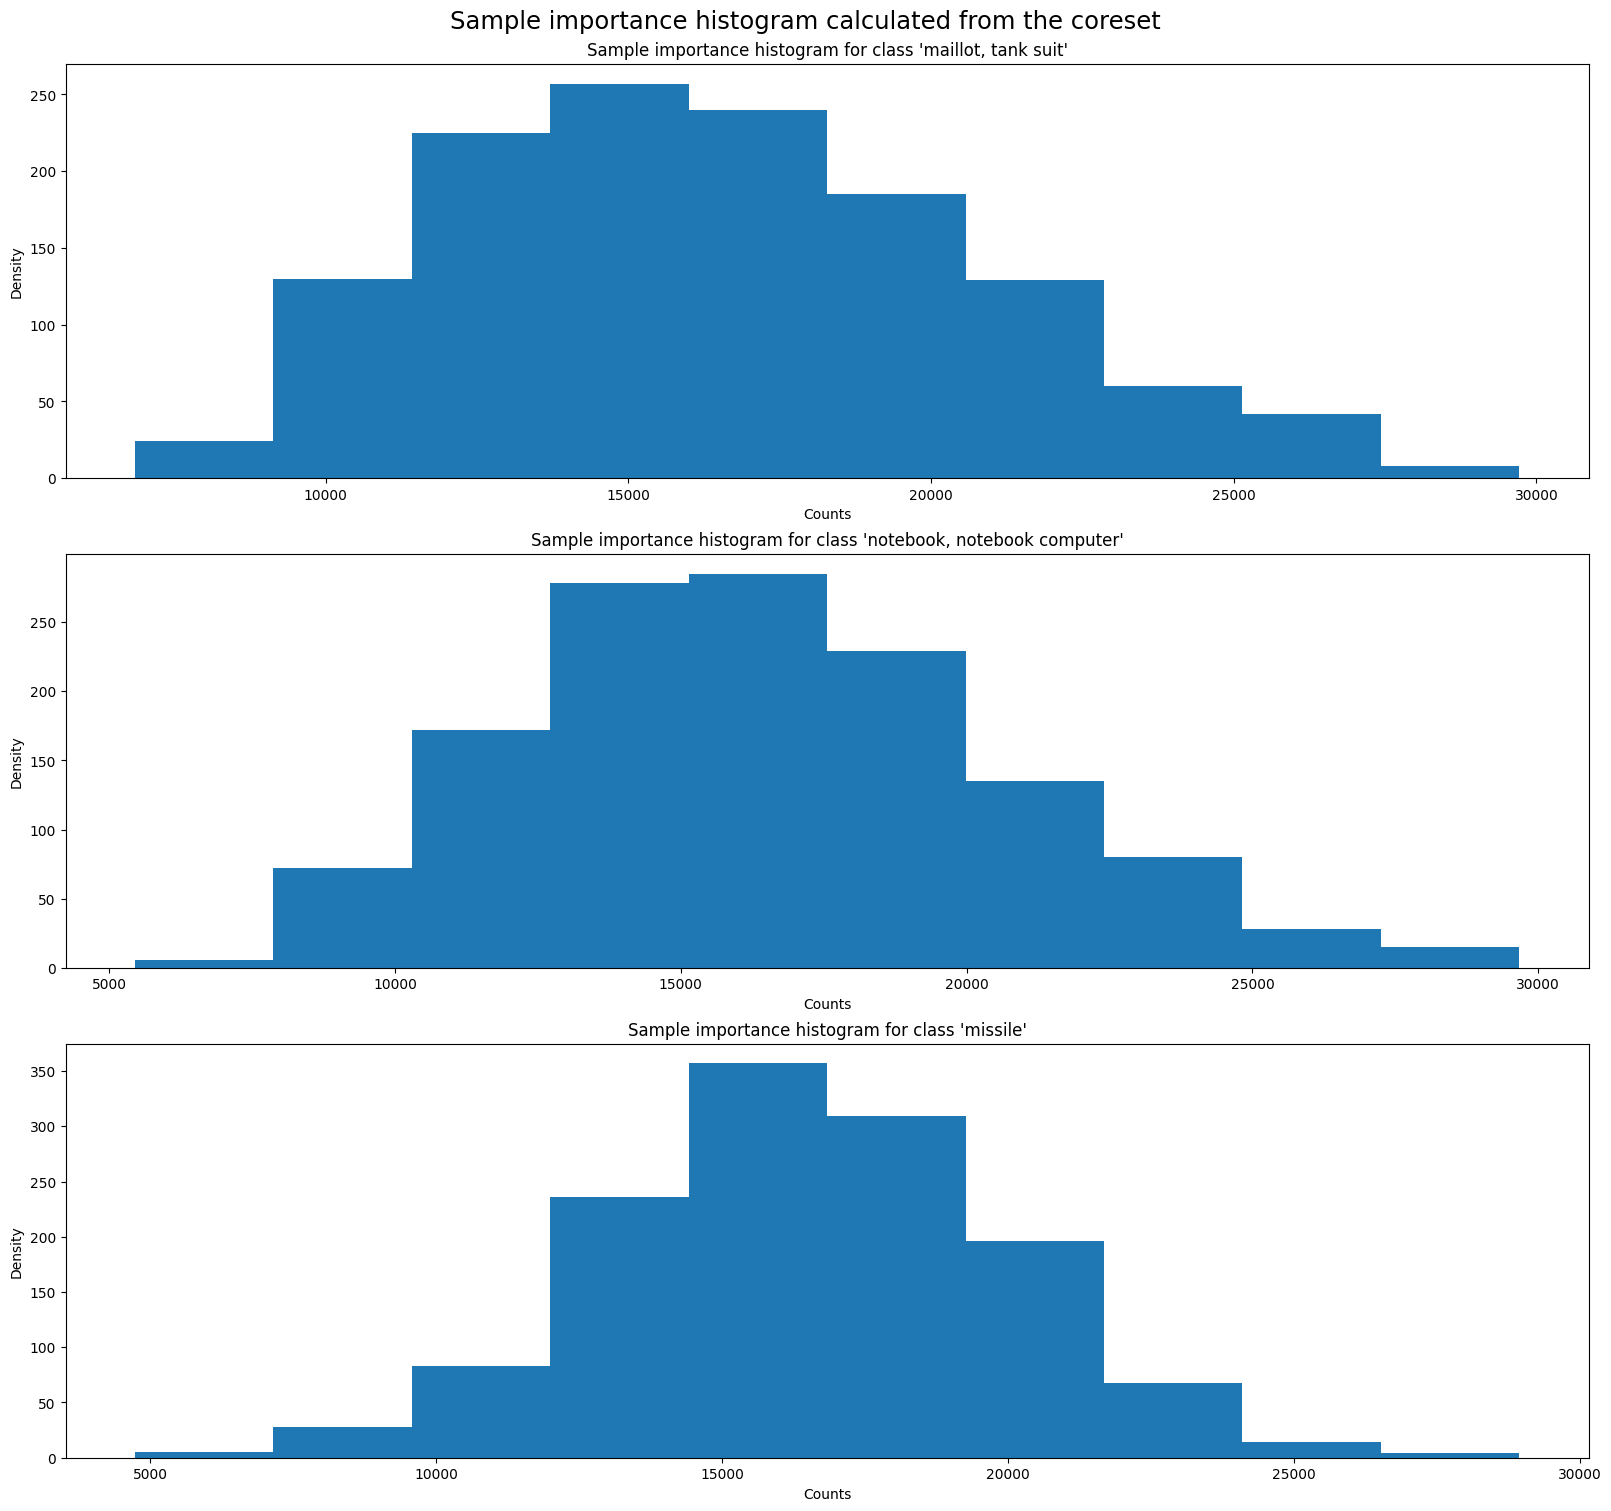

In [14]:
fig, ax = plt.subplots(num_important_classes, 1, figsize=(16, 15), constrained_layout=True)
fig.suptitle(f"Sample importance histogram calculated from the coreset", fontsize=17.5)
for class_rank in range(num_important_classes):
    ax[class_rank].set_title(f"Sample importance histogram for class "
                               f"\'{imagenet1k_class_names[predicted_class_ids[class_rank]]}\'")
    ax[class_rank].set_xlabel("Counts")
    ax[class_rank].set_ylabel("Density")
    _ = ax[class_rank].hist(importance_dict[class_rank], bins=10)

# Visualize samples sorted by importance

The objective is to visualize the data samples from the top and bottom ends of the importance spectrum based on the importance computed using the coreset service.

It is to note that the coreset service returns the indices and the importances in importances' descending order.

In [15]:
# Build a dictionary with lists of tuples of form (index, importance) for the classes of interest, ordered in
# descending order of importance
important_samples = {rank: list(zip(indices_dict[rank], importance_dict[rank])) for rank in
                     range(num_important_classes)}
# For each class, group the tuples in the list into `num_top_important_samples_per_class` elements to be processed by
# the visualisation utilities
top_samples = {rank: [tuple(important_samples[rank][i:i + num_top_important_samples_per_class]) for i in
                      range(0, len(important_samples[rank]), num_top_important_samples_per_class)] for rank in
               range(num_important_classes)}
# Build a dictionary with lists of tuples of form (index, importance) for the classes of interest, ordered in
# ascending order of importance
reverse_important_samples = {rank: important_samples[rank][::-1] for rank in range(num_important_classes)}
# For each class, group the tuples in the list into `num_bottom_important_samples_per_class` elements to be processed
# simultaneous by the visualisation utilities
bottom_samples = {rank: [tuple(reverse_important_samples[rank][i:i + num_bottom_important_samples_per_class]) for i in
                         range(0, len(reverse_important_samples), num_bottom_important_samples_per_class)] for rank in
                  range(num_important_classes)}

In [16]:
def visualize(samples_dict, num_samples_per_class):
    """
    Generator used to plot the relevant samples (top or bottom importance) for the classes of importance

    Args:
        samples_dict: dictionary of lists of `num_samples_per_class` consecutive tuples of indices and importance
        num_samples_per_class: no of samples to plot by one run of the generator
    """
    for tuples in zip(*samples_dict.values()):
        fig, ax = plt.subplots(num_samples_per_class, num_important_classes,
                               figsize=(3 * num_important_classes, 3 * num_samples_per_class), layout="tight")
        for class_rank in range(num_important_classes):
            for i in range(num_samples_per_class):
                ax[i, class_rank].axis('off')
                ax[i, class_rank].imshow(
                    mpimg.imread(dataset_path / 'raw' / train_images_paths[tuples[class_rank][i][0], 0][3:]),
                    aspect='equal')
                if i == 0:
                    ax[0, class_rank].title.set_text(
                        f"Label: \'{imagenet1k_class_names[predicted_class_ids[class_rank]]}\'\n"
                        f"\nidx={tuples[class_rank][i][0]}, "
                        f"impt.={tuples[class_rank][i][1]:.3f}")
                else:
                    ax[i, class_rank].title.set_text(
                        f"idx={tuples[class_rank][i][0]}, impt.={tuples[class_rank][i][1]:.3f}")
        yield

## Visualize top importance

The next step is to find hard-to-predict samples (unusual objects, occluded, multiple objects instead of one, etc.) or mislabeled samples within the top-importance samples.

In [17]:
top_importance_visualizer = visualize(top_samples, num_top_important_samples_per_class)
bottom_importance_visualizer = visualize(bottom_samples, num_bottom_important_samples_per_class)

## Top importance samples

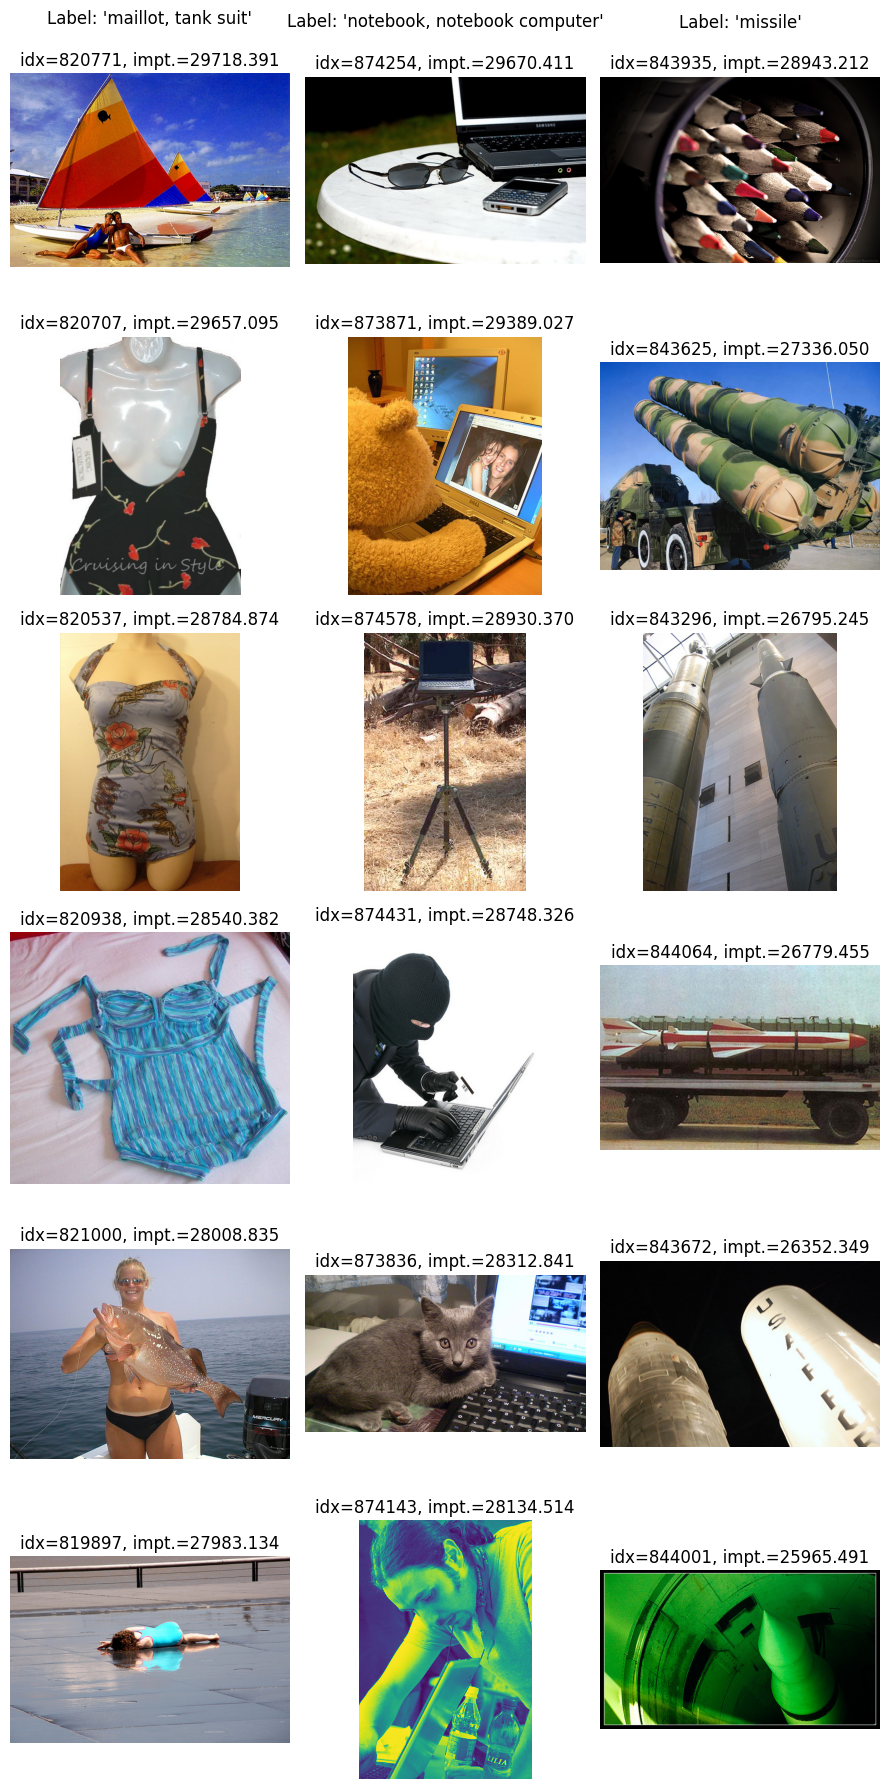

In [18]:
next(top_importance_visualizer)

Each column corresponds to one of the `numInportantClasses=3` classes of interest. For each class the most important sample is in the first row and the sixth important one is in the last row. Each row has the index of the image and its importance added as the image title. The first image of the `missile` class, as can be seen, is mislabeled (though there is some sort of resemblance). The second image of the `missile` class, although semantically connected, depicts a self-propelled launcher [Reference.1 - accessed 01.18.2023](https://en.missilery.info/missile/c300pmu1) and is, therefore, mislabeled too. The third and the fifth images of the `missile` class include two or more objects, that are not fully visible in the image, while the fourth and sixth images of the `missile` class have an unusual color or confusing background, making it harder to classify all these images and they, therefore, received a high importance.

The first image of the `notebook, notebook computer` class could be better classified as the `laptop, laptop computer` class (given the "\[...\] lightweight portability advantage" of notebooks over the laptops, [Reference.2 - accessed 01.18.2023](https://www.hp.com/us-en/shop/tech-takes/laptop-vs-notebook)), so it is mislabeled. All top 6 images of the `notebook, notebook computer` class exhibits at least some form of ambiguity because of the presence of other objects. Morover, in the first, second, fifth and the sixth images, the objects of reference are only partially visible. In addition, because all top important samples of this class could be easily classified as `laptop, laptop computer`, this emphasizes an underlying issue with these two classes of the dataset, since "\[c\]lass overlapping has long been regarded as one of the toughest pervasive problems in classificatio" [Reference.3 - accessed 01.18.2023](https://www.atlantis-press.com/article/2053.pdf)

The first image of the `maillot, tank suit` class, although including such an item (one person of the two is wearing it), is confusing, as the image contains more than a single object and the maillot is not dominant in the image. The fifth image in the class is clearly mislabeled. The sixth image of the `maillot, tank suit` class includes additional objects, making the classification more difficult.

## Bottom importance samples

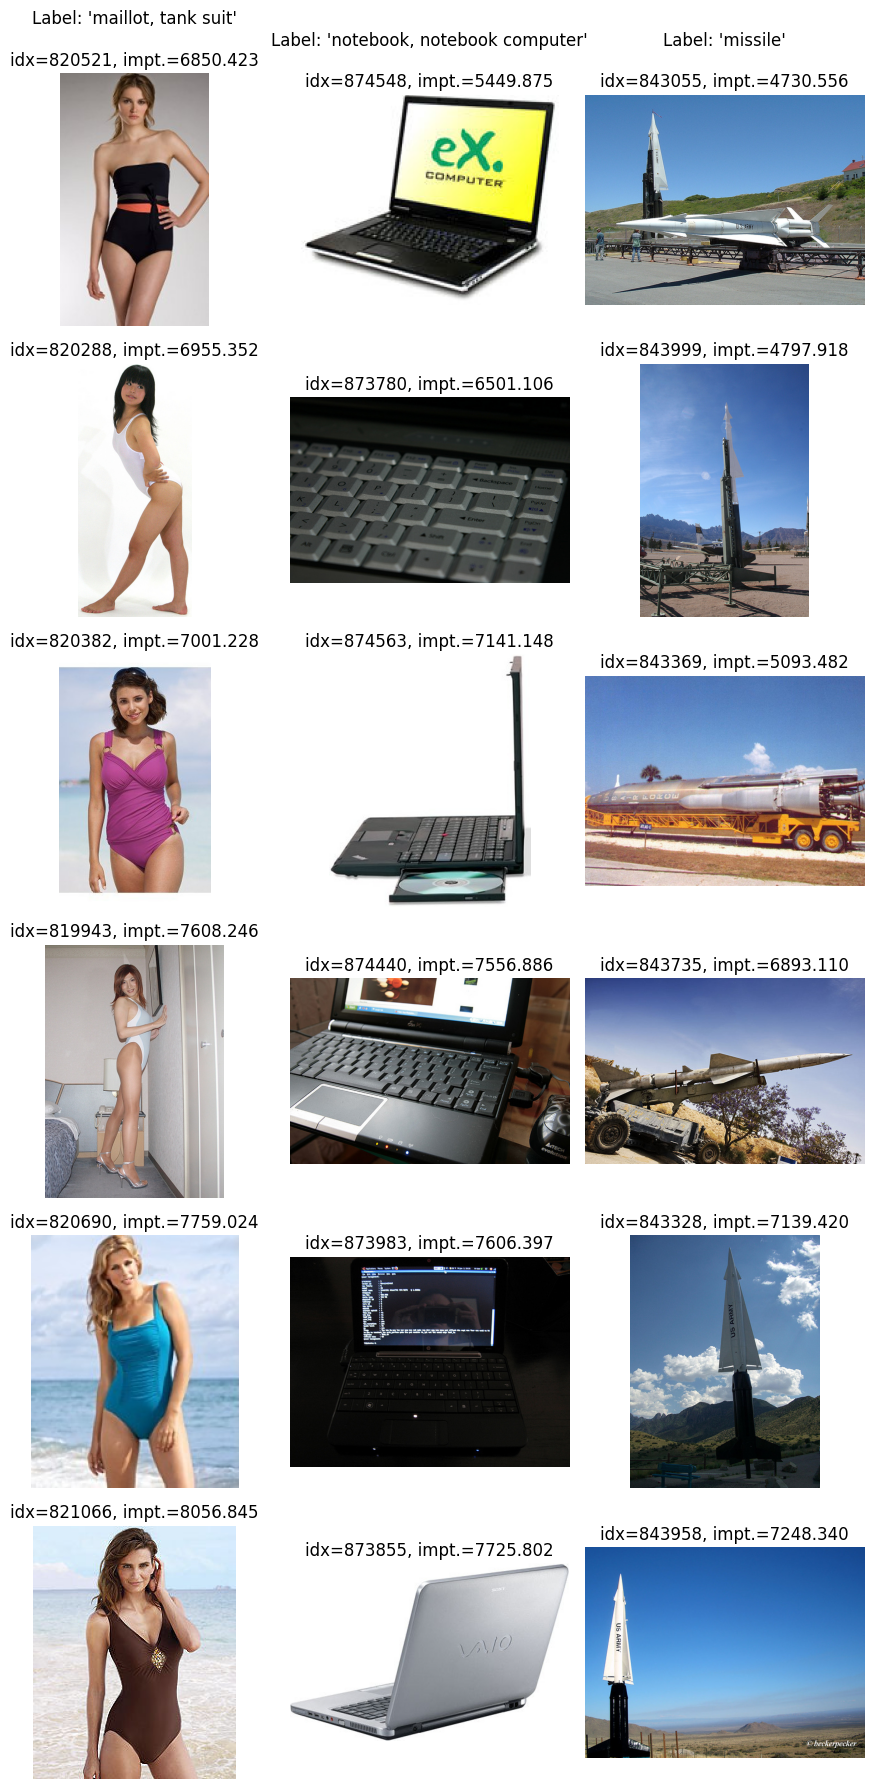

In [19]:
next(bottom_importance_visualizer)

Just like before, each column corresponds to one of the `numImportantClasses=3` classes of interest. For each class the least important sample is in the first row and the sixth least important one is in the last row. Each row has the index of the image and its importance added as the image title.

With the sole exception of the second image in the `notebook, notebook computer` class (which is hard to classify), all other images clearly belong to the indicated class and in the vast majority of the images there’s only a single item of the indicated class, making it much easier to classify the images.